In [26]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import torchmetrics.functional as metrics
import os
import shutil
from torchvision import transforms
from PIL import Image

In [27]:
# 학습 검증용 데이터
folder_path = 'data/train/train'
target_data = []
img_data = []
for encoding_label,label in enumerate(os.listdir(folder_path)):
    for img in os.listdir(folder_path+'/'+label):
        image_path = os.path.join(folder_path,label,img)
        with open(image_path, 'rb') as file:
            image = Image.open(file)
            # 이미지 크기 확인
            width, height = image.size
            if width == 48 and height == 48:
                image_array = np.array(image)
                
                target_data.append(encoding_label)
                img_data.append(image_array)

In [28]:
# 테스트용 데이터
folder_path_ = 'data/test/test'
target_test = []
img_test = []
for encoding_label,label in enumerate(os.listdir(folder_path)):
    for img in os.listdir(folder_path+'/'+label):
        image_path = os.path.join(folder_path,label,img)
        with open(image_path, 'rb') as file:
            image = Image.open(file)
            if width == 48 and height == 48:
                image_array = np.array(image)
                target_test.append(encoding_label)
                img_test.append(image_array)

In [33]:
# 이미지 데이터 정규화
x_data = np.array(img_data)/255.
x_data = x_data.reshape((-1,48*48))
print(x_data.shape)

(28709, 2304)


In [34]:
# 원핫 인코딩
# from sklearn.preprocessing import OneHotEncoder
# y_data = OneHotEncoder(sparse_output=False).fit_transform(np.array(target_data).reshape(-1,1))

In [35]:
# 데이터 클래스 생성
class DLdataset(Dataset):
    
    def __init__(self,x_data,y_data):
        super().__init__()
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.LongTensor(y_data)
        
    def __len__(self):
        return self.target.shape[0]
    
    def __getitem__(self,idx):
        return self.feature[idx], self.target[idx]

In [36]:
# 데이터셋 생성
dataset = DLdataset(x_data,target_data)

In [37]:
# 학습용, 검증용 데이터 준비
seed = torch.Generator().manual_seed(42)
trainDS, validDS = random_split(dataset, [0.8,0.2], generator=seed)

In [38]:
# 배치사이즈 32
BATCH = 32
trainDL = DataLoader(trainDS, batch_size=BATCH)
validDL = DataLoader(validDS, batch_size=BATCH)

In [39]:
# 모델 클래스 정의
class Model(nn.Module):
    
    def __init__(self, IN, OUT):
        super().__init__()
        self.input = nn.Linear(IN, 128) 
        self.af = nn.ReLU()
        self.hidden = nn.Linear(128, 32)
        self.output = nn.Linear(32, OUT)
        
    def forward(self, x):
        y = self.input(x)
        y = self.af(y)
        y = self.hidden(y)
        y = self.af(y)
        y = self.output(y)
        
        return y

In [40]:
# 학습 준비

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 100

IN = dataset.feature.shape[1]
OUT = pd.Series(target_data).nunique()

# 모델 생성
model  = Model(IN,OUT)

# 손실함수
LF = nn.CrossEntropyLoss().to(DEVICE)

# 옵티마이저
OPTIMIZER = torch.optim.Adam(model.parameters())

# 스케줄러
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 3)

In [41]:
def training(dataLoader):
    
    model.train()
    train_report=[[], []]
    for (feature, target) in dataLoader:

        feature, target = feature.to(DEVICE), target.to(DEVICE)
        
        # 학습
        pre_target = model(feature)
        
        # 손실계산
        loss = LF(pre_target, target)
        train_report[0].append(loss)
  
        # 성능 평가
        acc = metrics.accuracy(pre_target.argmax(dim=1), target, task = 'multiclass',num_classes=OUT)
        train_report[1].append(acc)
        
        # W,b업데이트
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()

    loss_score = sum(train_report[0])/len(train_report[0])
    acc_score = sum(train_report[1])/len(train_report[1])
    print(f'[Train loss] ==> {loss_score}    [Train Accuracy] ==> {acc_score}')
    return loss_score, acc_score

In [43]:
def testing(dataLoader):
    
    model.eval()
    
    with torch.no_grad():
        test_report=[[], []]
        for (feature, target)  in dataLoader:
            # 배치크기만큼의 학습 데이터 준비
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            
            # 학습
            pre_target = model(feature)
            
            # 손실계산
            loss = LF(pre_target, target)
            test_report[0].append(loss)
      
            # 성능 평가
            acc = metrics.accuracy(pre_target.argmax(dim=1), target, task = 'multiclass',num_classes=OUT)
            test_report[1].append(acc)
    
        loss_score = sum(test_report[0])/len(test_report[0])
        acc_score = sum(test_report[1])/len(test_report[1])

    print(f'[Test loss] ==> {loss_score}    [Test Accuracy] ==> {acc_score}')
    return loss_score, acc_score

In [52]:
def grahp(train_report,val_report):
    fig, ax1 = plt.subplots()  # fig는 그래프 객체

    # 손실 그래프 그리기
    ax1.plot(train_report[0], label='Train Loss', color='red')
    ax1.plot(val_report[0], label='Validation Loss', color='orange')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')
    
    # 정확도 그래프 그리기
    ax2 = ax1.twinx()
    ax2.plot(train_report[1], label='Train Accuracy', color='blue')
    ax2.plot(val_report[1], label='Validation Accuracy', color='green')
    ax2.set_ylabel('Accuracy & F1')
    ax2.set_xlabel('Epoch')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper right')
    
    plt.xlabel('Epoch')  # 전체 그래프의 x축 라벨 설정
    plt.title('Train & Validation Scores')
    plt.show()

In [80]:
def predicting(dataset,n,filename):
# 0:angry / 1:disgust / 2:fear / 3:happy / 4:neutral / 5:sad / 6:surprise
    label = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
    model_path = 'model/'+filename
    model.load_state_dict(torch.load(model_path))
    model.eval()

    correct = 0
    total = 0

    for idx in range(len(dataset)):
        img, ytrue = dataset[idx][0], dataset[idx][1]

        with torch.no_grad():
            ypre = model(img.unsqueeze(0))
            ypre = torch.argmax(ypre, dim=1).item()
            

            if ypre == ytrue:
                correct += 1
            
            total += 1
            if idx < n :
                plt.imshow(dataset[idx][0].numpy().reshape(48, 48), cmap='gray_r')
                plt.title(f'[{idx+1}] True {label[ytrue]} / Predict {label[ypre]}')
                plt.xticks([])
                plt.yticks([])
                plt.show()


    accuracy = correct / total
    print(f'Accuracy: {accuracy:.2f}, Correct : {correct}, Total : {total}')
    return accuracy

In [71]:

dir = 'model/'
filepath=dir+'main_model.pth'
if not os.path.exists(dir):
    os.makedirs(dir)
min_loss = 100.0  # 초기 최소 손실 설정
train_report = [[],[]]
val_report = [[],[]]
for eps in range(EPOCHS):
    print(f'[{eps+1}/{EPOCHS}]')
    # 학습
    train_loss, train_acc = training(trainDL)
    train_report[0].append(train_loss.item())
    train_report[1].append(train_acc.item())
    
    # 검증
    val_loss, val_acc = testing(validDL)
    val_report[0].append(val_loss.item())
    val_report[1].append(val_acc.item())
    # 최소 손실 업데이트
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), filepath)


    # 조기 종료 기능 => 조건 : val_loss가 지정된 횟수 이상 개선이 안되면 학습 종료
    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
        print(f"Early stopping at epoch {eps}")
        break

[1/100]
[Train loss] ==> 1.2518361806869507    [Train Accuracy] ==> 0.5230965614318848
[Test loss] ==> 2.0076656341552734    [Test Accuracy] ==> 0.368028849363327
[2/100]
[Train loss] ==> 1.2499566078186035    [Train Accuracy] ==> 0.5213991403579712
[Test loss] ==> 1.9887478351593018    [Test Accuracy] ==> 0.3641960620880127
[3/100]
[Train loss] ==> 1.2630139589309692    [Train Accuracy] ==> 0.5179752707481384
[Test loss] ==> 2.039987087249756    [Test Accuracy] ==> 0.3662927448749542
[4/100]
[Train loss] ==> 1.244713544845581    [Train Accuracy] ==> 0.5216892957687378
[Test loss] ==> 2.008920907974243    [Test Accuracy] ==> 0.3710469901561737
[5/100]
[Train loss] ==> 1.2562153339385986    [Train Accuracy] ==> 0.5218343734741211
[Test loss] ==> 1.9981504678726196    [Test Accuracy] ==> 0.36733439564704895
[6/100]
[Train loss] ==> 1.2487746477127075    [Train Accuracy] ==> 0.5223711729049683
[Test loss] ==> 2.0493252277374268    [Test Accuracy] ==> 0.36394229531288147
[7/100]
[Train los

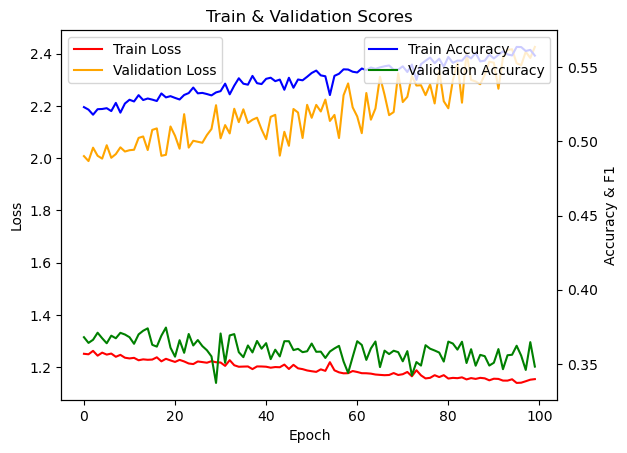

In [72]:
fig, ax1 = plt.subplots()

ax1.plot(train_report[0], label='Train Loss', color='red')
ax1.plot(val_report[0], label='Validation Loss', color='orange')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# 정확도 그래프 그리기
ax2 = ax1.twinx()
ax2.plot(train_report[1], label='Train Accuracy', color='blue')
ax2.plot(val_report[1], label='Validation Accuracy', color='green')
ax2.set_ylabel('Accuracy & F1')
ax2.set_xlabel('Epoch')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.xlabel('Epoch')  # 전체 그래프의 x축 라벨 설정
plt.title('Train & Validation Scores')
plt.show()

In [74]:
x_test = np.array(img_test)/255.
x_test = x_test.reshape((-1,48*48))
target_test = np.array(target_test)
data = np.concatenate([x_test,target_test.reshape(-1,1)], axis=1)

In [75]:
np.random.shuffle(data)

In [76]:
testDS = DLdataset(data[:,:-1],data[:,-1])

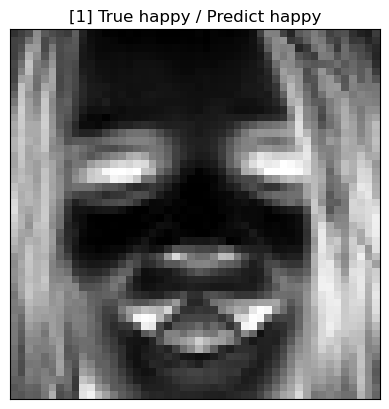

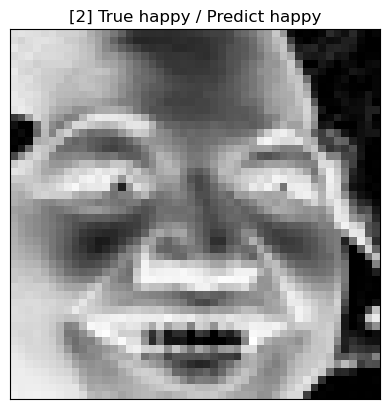

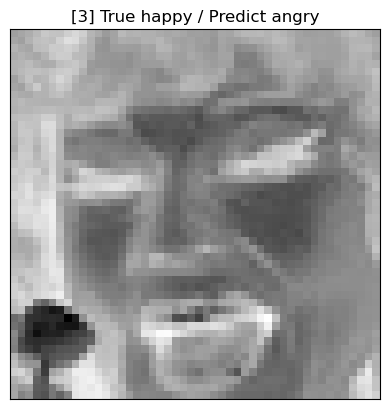

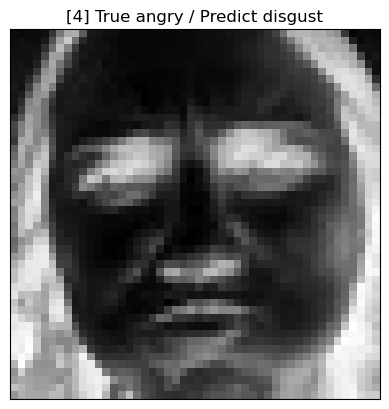

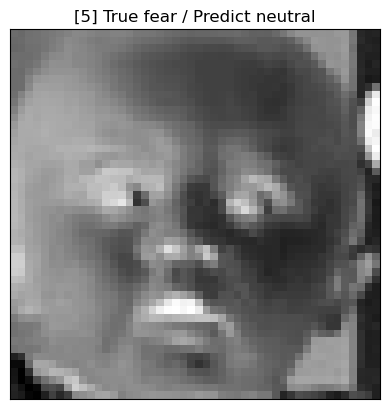

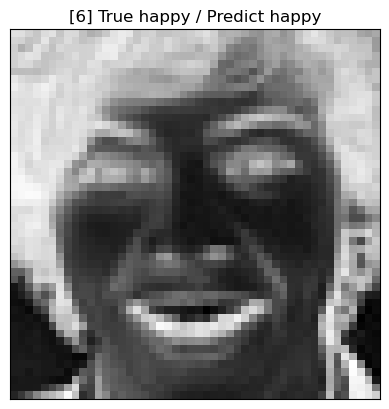

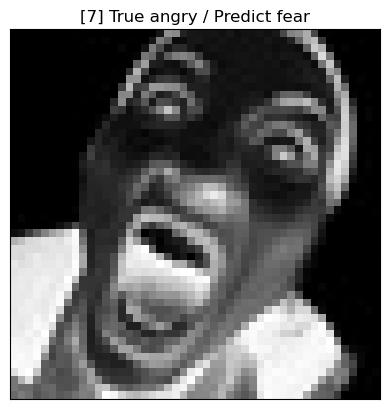

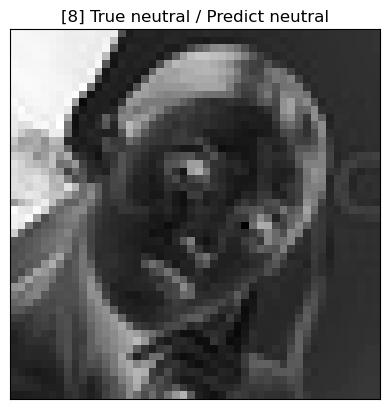

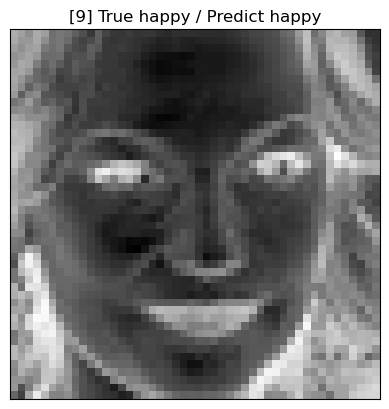

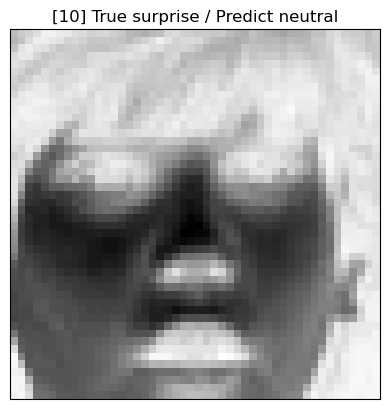

Accuracy: 0.45, Correct : 12938, Total : 28709


0.45066007175450207

In [82]:
predicting(testDS, 10,'main_model.pth')